## Make bathymetry binary file based on netCDF bathy file bahia01_smooth_bat.nc

In this notebook we prepare a bathymetry file for MITgcm based on the bathymetry developed by Esteban Cruz of a semi circular bay with no shelf (only slope). The bay is 120 km long and has a maximum depth of 160 m. The maximum depth in the domain is 1000 m.

We will make a bathymetry for a domain of size nx = 240, ny = 180, and a horizontal spacing of approximately 2 km (a coarse bathymetry, the real dx is 1.983 km and dy is 2.327 km).

The model will have 40 z levels of varying dz (starting from 2 m at the surface and increasing in thickness by 10.45% with each level).

The next bathimetries will include an elongated domain alongshore of increasing dx (telescopic) to avoid recirculation since AS boundaries will be periodic, and longer cross-shelf distance.

In [1]:
from netCDF4 import Dataset
import cmocean as cmo
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as sci_interp

In [2]:
#nc_file = 'bahia01_noShelf_bat.nc'
nc_file = 'bahia01_smooth_bat.nc'

with Dataset(nc_file, 'r') as nbl:
    print(nbl.variables)

{'X': <class 'netCDF4._netCDF4.Variable'>
float32 X(y, x)
    units: meters
    description: Coordenadas X del dominio
unlimited dimensions: 
current shape = (1795, 2380)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Y': <class 'netCDF4._netCDF4.Variable'>
float32 Y(y, x)
    units: meters
    description: Coordenadas Y del dominio
unlimited dimensions: 
current shape = (1795, 2380)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Z': <class 'netCDF4._netCDF4.Variable'>
float32 Z(y, x)
    units: meters
    description: Datos de profundidad del dominio Z
unlimited dimensions: 
current shape = (1795, 2380)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Z_sm': <class 'netCDF4._netCDF4.Variable'>
float32 Z_sm(y, x)
    units: meters
    description: Datos suavizados de profundidad del dominio Z
unlimited dimensions: 
current shape = (1795, 2380)
filling on, default _FillValue of 9.969209968386869e+36 used}


In [3]:
with Dataset(nc_file, 'r') as nbl:
    Xog = nbl.variables['X'][:].data
    Yog = nbl.variables['Y'][:].data
    Z = nbl.variables['Z_sm'][:].data

In [4]:
# Show corners of the original bathymetry
print(f'left x-limit is {np.min(Xog)} m, and right x-limit is {np.max(Xog)} m')
print(f'bottom y-limit is {np.min(Yog)} m, and top y-limit is {np.max(Yog)} m')

left x-limit is -238000.0 m, and right x-limit is 237820.0 m
bottom y-limit is -62000.0 m, and top y-limit is 356789.90625 m


In [5]:
# Set desired number of grid points along x and y
nx = 240
ny = 180

# Build x and y arrays for new bathymetry
x_min = -238E3 # m
x_max =  238E3
y_min = -62000
y_max = 357E3

x_vect = np.round(np.linspace(x_min, x_max, nx), decimals=1)
y_vect = np.round(np.linspace(y_min, y_max ,ny), decimals=1)

# Create interp function from original x, y and depth
f_interp = sci_interp.interp2d(Xog[0,:], Yog[:,0], Z)

# Interpolate into desired x and y vectors
bathy = f_interp(x_vect,y_vect)

/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_2402/3089329722.py:15: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f_interp = sci_interp.interp2d(Xog[0,:], Yog[:,0], Z)
/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_2402/3089329722.py:18: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids 

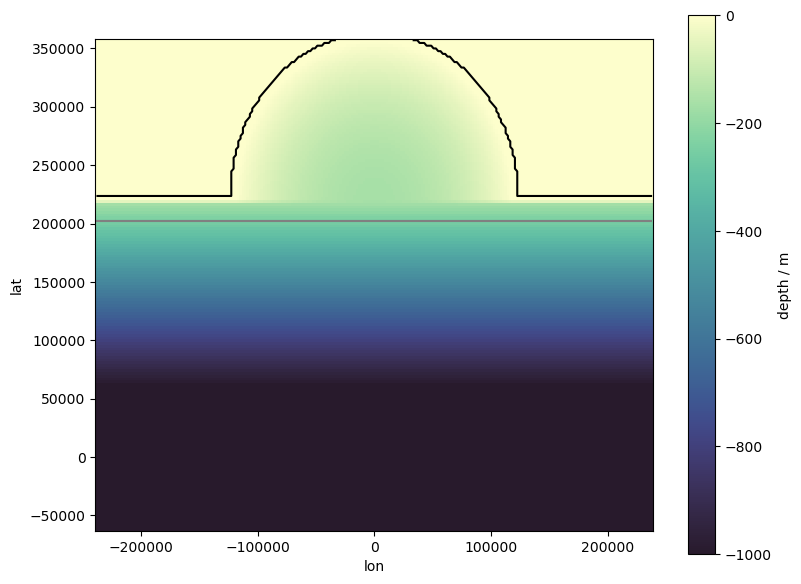

In [6]:
# Plot interp bathymetry
fig, ax = plt.subplots(1,1,figsize=(9,7))
pc = ax.pcolormesh(x_vect,y_vect,bathy, cmap=cmo.cm.deep_r)
cb = plt.colorbar(pc)

ax.contour(x_vect,y_vect,-bathy, colors='0.5', levels=[250])
ax.contour(x_vect,y_vect,-bathy, colors='k', levels=[0])

cb.set_label('depth / m')
ax.set_xlabel('lon')
ax.set_ylabel('lat')

ax.set_aspect(1)

Text(0, 0.5, 'Depth (m)')

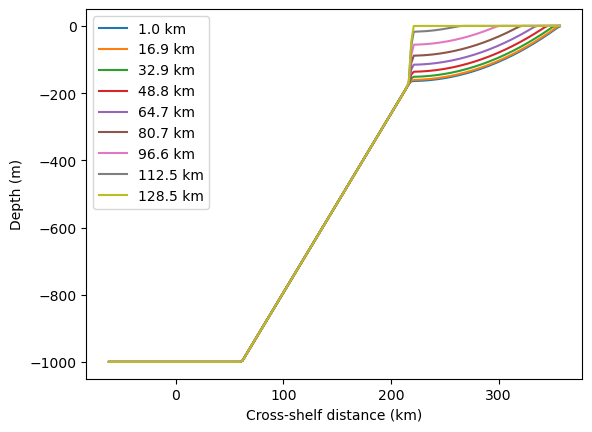

In [7]:
# Check some cross-shelf profiles starting from the center of the bay (0 km)
for ii in range(120,186,8):
    plt.plot(y_vect[:]/1E3,bathy[:,ii], label=f'{x_vect[ii]/1E3:1.1f} km')
plt.legend()
plt.xlabel('Cross-shelf distance (km)')
plt.ylabel('Depth (m)')

In [8]:
# Build grid spacing vectors dx and dy 
delx = x_vect[1:]-x_vect[:-1]
dely = y_vect[1:]-y_vect[:-1]
dx = np.append(delx, [delx[-1]], axis=0) # This is not the best way to do this
dy = np.append(dely, [dely[-1]], axis=0)

#Check values:
print(dx)
print(dy)

[1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6
 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6
 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7
 1991.6 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7
 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6
 1991.6 1991.7 1991.6 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6
 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6
 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.6 1991.7 1991.6 1991.6
 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7
 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.6 1991.7
 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6
 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6
 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6
 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7 1991.6 1991.6 1991.7
 1991.

In [9]:
# Set filenames for binary files and data type
#bathy_fname = 'bahia_01_noShelf_bat.bin'
#dx_fname = 'bahia_01_noShelf_dx.bin'
#dy_fname = 'bahia_01_noShelf_dy.bin'
#dt = np.dtype('>f8')  # float 64 big endian

In [10]:
bathy_fname = 'bahia_01_smooth_bat.bin'
dx_fname = 'bahia_01_smooth_dx.bin'
dy_fname = 'bahia_01_smooth_dy.bin'
dt = np.dtype('>f8')  # float 64 big endian

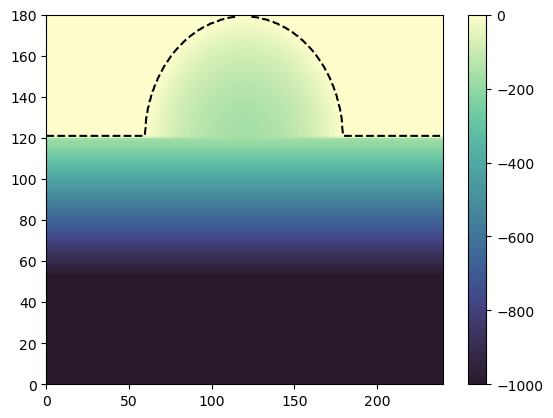

In [11]:
# Save binary files for dx, dy, bathy
fileobj = open(dx_fname,mode='wb')
dx.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(dy_fname, mode='wb')
dy.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(bathy_fname, mode='wb')
dd=bathy
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

# Quick check
plt.pcolor(dd, cmap=cmo.cm.deep_r)
plt.colorbar()
plt.contour(dd, levels=[-1,0], colors='k')
plt.show()

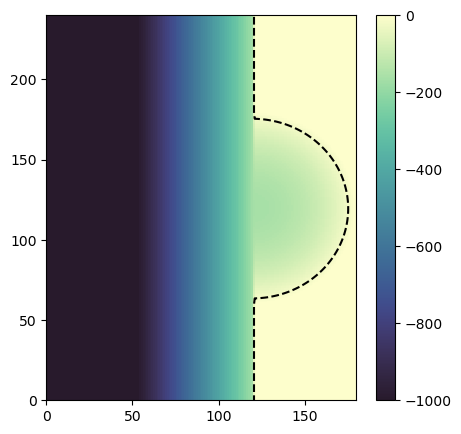

In [12]:
# Check it is read correctly
cc=np.fromfile(bathy_fname, dtype=dt)
np.shape(cc)

bF=np.reshape(cc,[nx,ny],'F') # F to read in Fortran order

fig,ax = plt.subplots(1,1, figsize=(5,5))

pc = ax.pcolormesh(bF, cmap=cmo.cm.deep_r)
plt.colorbar(pc,ax=ax)
ax.contour(bF, levels=[-20,0], colors='k')

Yes, that is how it should look to go into MITgcm.

In [13]:
sNx =   16
sNy =   12
OLx =   3
OLy =   3
nSx =   15
nSy =   15
nPx =   1
nPy =   1

In [14]:
Nx  = sNx*nSx*nPx
print(Nx)

240
